# Time Series Prediction with LSTM (IOT Data)

### Abstract
This Jupyter notebook demonstrates the use of Microsoft CNTK to perform a time series prediction task using IOT data.

Here, a recurrent neural network, more specifically a Long Short Term Memory (LSTM) is used.

Adapted from: https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_106B_LSTM_Timeseries_with_IOT_Data.ipynb

##### Tested on Microsoft CNTK V2.0 Beta 15 (https://github.com/Microsoft/CNTK/)

##### Overview:
1. Import Libraries 
2. Configure Parameters
3. Pre-process Data
4. Configure Reader
5. Preview Data
6. Configure LSTM Network
7. Train
8. Evaluate
9. Visualize Prediction

### Step 1: Import Libraries

In [1]:
from matplotlib import pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import random
import time

import cntk as C
import cntk.axis
from cntk.layers import Input, Dense, Dropout, Recurrence 

try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

%matplotlib inline

### Step 2: Configure Parameters

In [2]:
# to make things reproduceable, seed random
np.random.seed(0)

In [3]:
isFast = True

# we need around 2000 epochs to see good accuracy. For testing 100 epochs will do.
EPOCHS = 100 if isFast else 2000

### Step 3: Pre-process Data
Most of the code in this example is related to data preparation. Thankfully the pandas library make this easy.

`preprocess_iot_data()` function performs the following tasks:
- read raw data into a pandas dataframe, 
- normalize the data, 
- groups by day and 
- append the columns "F1Amp.max", and
- generates the sequences for each day.

*Sequence generation*: All sequences are concatenated into a single list of sequences. There is *no more notion of timestamp* in our train input and **only** the sequences matter.

**Note** if we have less than <i>n</i> datapoints for a day we skip over the day assuming something is missing in the raw data. If we get more than <i>m</i> data points in a day we truncate the readings.

#### Training / Testing / Validation data preparation
We start by reading the csv file for use with CNTK.  The raw data is sorted by time and we should randomize it before splitting into training, validation and test datasets but this would make it impractical to visualize results in the tutorial. Hence, we split the dataset in the following manner: pick in sequence, 8 values for training, 1 for validation and 1 for test until there is no more data. This will spread training, validation and test datasets across the full timeline while preserving time order.


In [4]:
def preprocess_iot_data(time_steps, normalize=1, val_size=0.1, test_size=0.1):
    """
    generate sequences to feed to rnn based on data frame with iot data
    the csv has has the format: time, sensor value
    """
    # try to find the data file local. 
    cache_path = os.path.join("data", "cmc")
    cache_file = os.path.join(cache_path, "idnode39.csv")
    
    # read file
    df = pd.read_csv(cache_file, index_col='ReadingTime', parse_dates=['ReadingTime'], dtype=np.float32)
    
    # display properties of the dataset
    print(df.describe())
    
    # set the date as the index
    df["date"] = df.index.date
    
    # normalize the sensor data
    df['F1Amp'] /= normalize
    
    # group by day, find the max for a day and add a new column .max
    grouped = df.groupby(df.index.date).max()
    grouped.columns = ["F1Amp.max", "date"]

    # merge continuous readings and daily max values into a single frame
    df_merged = pd.merge(df, grouped, right_index=True, on="date")
    df_merged = df_merged[["F1Amp", 
                           "F1Amp.max"]]
    
    # we group by day so we can process a day at a time.
    grouped = df_merged.groupby(df_merged.index.date)
    per_day = []
    for _, group in grouped:
        per_day.append(group)

    # split the dataset into train, validatation and test sets on day boundaries
    val_size = int(len(per_day) * val_size)
    test_size = int(len(per_day) * test_size)
    next_val = 0
    next_test = 0

    result_x = {"train": [], "val": [], "test": []}
    result_y = {"train": [], "val": [], "test": []}    

    # generate sequences a day at a time
    for i, day in enumerate(per_day):
        # if we have less than n datapoints for a day we skip over the
        # day assuming something is missing in the raw data
        total = day["F1Amp"].values
        # here, we set n = 40
        if len(total) < 40:
            continue
        if i >= next_val:
            current_set = "val"
            next_val = i + int(len(per_day) / val_size)
        elif i >= next_test:
            current_set = "test"
            next_test = i + int(len(per_day) / test_size)
        else:
            current_set = "train"
        max_total_for_day = np.array(day["F1Amp.max"].values[0])
        for j in range(2, len(total)):
            result_x[current_set].append(total[0:j])
            result_y[current_set].append([max_total_for_day])
            if j >= time_steps:
                break
    # make result_y a numpy array
    for ds in ["train", "val", "test"]:
        result_y[ds] = np.array(result_y[ds])
    return result_x, result_y

In [5]:
# there are 100 lstm cells, 1 for each possible reading we get per day
TIMESTEPS = 100

# 5 is the maximum total output in our dataset. We normalize all values with 
# this so our inputs are between 0.0 and 1.0 range.
NORMALIZE = 5

X, Y = preprocess_iot_data(TIMESTEPS, normalize=NORMALIZE)

              F1Amp
count  80000.000000
mean       2.002271
std        0.804392
min        0.112540
25%        1.409646
50%        2.108455
75%        2.622752
max        4.339578


### Step 4: Configure Reader

`next_batch()` yields the next batch for training. 

CNTK supports variable size sequences and batches are a list of numpy arrays where the numpy arrays have variable length. 

A standard practice is to shuffle batches with each epoch. We don't do this here because we want to be able to graph the data that is easily interpretable.

In [6]:
# process batches of 10 days
BATCH_SIZE = TIMESTEPS * 10

def next_batch(x, y, ds):
    """get the next batch for training"""

    def as_batch(data, start, count):
        return data[start:start + count]

    for i in range(0, len(x[ds]), BATCH_SIZE):
        yield as_batch(X[ds], i, BATCH_SIZE), as_batch(Y[ds], i, BATCH_SIZE)

### Step 5: Preview Data
You can now see the sequence we are going to feed to the LSTM. Note if we have less than <i>n</i> datapoints for a day we skip over the day assuming something is missing in the raw data. If we get more than <i>m</i> data points in a day we truncate the readings.

In [7]:
X['train'][0:3]

[array([ 0.25714779,  0.25714779], dtype=float32),
 array([ 0.25714779,  0.25714779,  0.22703759], dtype=float32),
 array([ 0.25714779,  0.25714779,  0.22703759,  0.22703759], dtype=float32)]

In [8]:
Y['train'][0:3]

array([[ 0.31792501],
       [ 0.31792501],
       [ 0.31792501]], dtype=float32)

### Step 6: Configure LSTM network

Corresponding  to the maximum possible <i>n</i> data points in the input sequence, we model our network with n LSTM cells, 1 cell for each data point we take during the day. Since the input sequences can be between n and m data points per sequence, we take the advantage of CNTK support for variable sequences as input to a LSTM so we can feed our sequences as-is with no additional need for padding.

The outputs from the LSTMs are feed into a dense layer and we randomly dropout 20% of the values to not overfit the model to the training set. The output of the dense layer becomes the prediction our model generates.

Notice: We lost the timestamp altogether; in our model only the sequences of readings matter. 

Our LSTM model has the following design:
![lstm](https://guschmueds.blob.core.windows.net/datasets/2.png)

The network model is an exact translation of the network diagram above.

In [9]:
def create_model(x):
    """Create the model for time series prediction"""
    with C.layers.default_options(initial_state = 0.1):
        m = C.layers.Recurrence(C.layers.LSTM(TIMESTEPS))(x)
        m = C.sequence.last(m)
        m = C.layers.Dropout(0.2)(m)
        m = cntk.layers.Dense(1)(m)
        return m

### Step 7: Train
Before we can start training we need to bind our input variables for the model and define what optimizer we want to use. For this example we choose the `adam` optimizer. We choose `squared_error` as our loss function.

In [10]:
# input sequences
x = C.layers.Input(1)

# create the model
z = create_model(x)

# expected output (label), also the dynamic axes of the model output
# is specified as the model of the label input
l = C.layers.Input(1, dynamic_axes=z.dynamic_axes, name="y")

# the learning rate
learning_rate = 0.005
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)

# loss function
loss = C.ops.squared_error(z, l)

# use squared error to determine error for now
error = C.ops.squared_error(z, l)

# use adam optimizer
momentum_time_constant = C.learner.momentum_as_time_constant_schedule(BATCH_SIZE / -math.log(0.9)) 
learner = C.learner.adam_sgd(z.parameters, 
                             lr = lr_schedule, 
                             momentum = momentum_time_constant)
trainer = C.Trainer(z, (loss, error), [learner])

Time to start training.

In [11]:
# training
loss_summary = []

start = time.time()
for epoch in range(0, EPOCHS):
    for x_batch, l_batch in next_batch(X, Y, "train"):
        trainer.train_minibatch({x: x_batch, l: l_batch})
        
    if epoch % (EPOCHS / 10) == 0:
        training_loss = C.utils.get_train_loss(trainer)
        loss_summary.append(training_loss)
        print("epoch: {}, loss: {:.4f}".format(epoch, training_loss))

print("Training took {:.1f} sec".format(time.time() - start))

epoch: 0, loss: 0.0002
epoch: 10, loss: 0.0313
epoch: 20, loss: 0.0153
epoch: 30, loss: 0.0070
epoch: 40, loss: 0.0050
epoch: 50, loss: 0.0049
epoch: 60, loss: 0.0049
epoch: 70, loss: 0.0049
epoch: 80, loss: 0.0050
epoch: 90, loss: 0.0050
Training took 1711.6 sec


A look how the loss function shows how the model is converging:

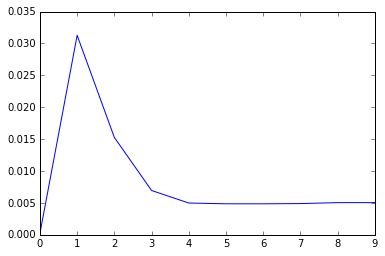

In [12]:
plt.plot(loss_summary, label='training loss');

### Step 8: Evaluate
Let us validate the training validation and test dataset. We use mean squared error as measure which might be a little simplistic. A method that would define a ratio how many predictions have been inside a given tolerance would make a better measure.

In [13]:
# validate
def get_mse(X,Y,labeltxt):
    result = 0.0
    for x1, y1 in next_batch(X, Y, labeltxt):
        eval_error = trainer.test_minibatch({x : x1, l : y1})
        result += eval_error
    return result/len(X[labeltxt])

In [14]:
# Print the train and validation errors
for labeltxt in ["train", "val"]:
    print("mse for {}: {:.6f}".format(labeltxt, get_mse(X, Y, labeltxt)))

mse for train: 0.000004
mse for val: 0.000005


In [15]:
# Print the test error
labeltxt = "test"
print("mse for {}: {:.6f}".format(labeltxt, get_mse(X, Y, labeltxt)))

mse for test: 0.000004


### Step 9: Visualize Prediction

Our model has been trained well, given the train, validation and test errors are in the same ball park. Predicted time series data renders well with visualization of the results. Let us take our newly created model, make predictions and plot them against the actual readings.

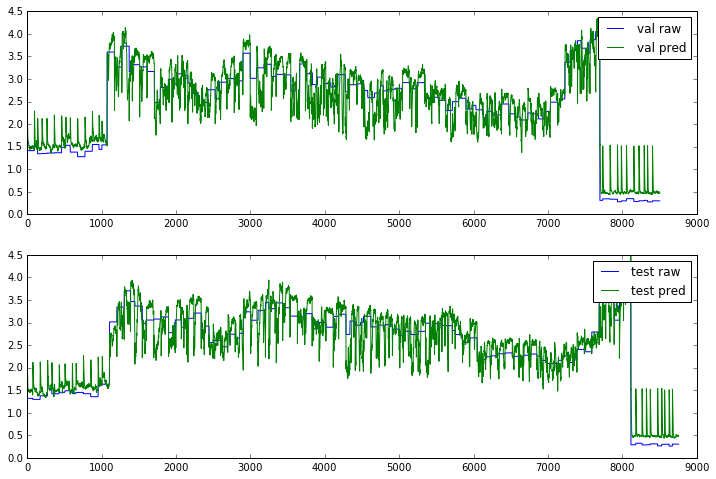

In [16]:
# predict
f, a = plt.subplots(2, 1, figsize=(12, 8))
for j, ds in enumerate(["val", "test"]):
    results = []
    for x_batch, _ in next_batch(X, Y, ds):
        pred = z.eval({x: x_batch})
        results.extend(pred[:, 0])
    # because we normalized the input data we need to multiply the prediction
    # with SCALER to get the real values.
    a[j].plot((Y[ds] * NORMALIZE).flatten(), label=ds + ' raw');
    a[j].plot(np.array(results) * NORMALIZE, label=ds + ' pred');
    a[j].legend();

If we let the model train for 2000 epochs the predictions are close to the actual data and follow the right pattern.

# Suggested activity

So what we do with this model? A practical application would be to generate alerts if the actual output is not in line with the prediction, for example if one of the panels is failing. The solar array that goes with our dataset has 16 panels. If we'd want to detect failure without generating false alerts, the accuracy of our prediction would need to be at least 1 - 1/16, around 94%. Our model is close to this but would most likely generate occasional false alerts.

- Improve the model by training for more epochs.
- Further preprocess the training set to smooth-out missing values
- Try out more complex networks.

However, in our experience with time series data one can achieve significant accuracy improvement comes from higher resolution training data, for example reading a data point every 5 minutes instead of every 30 minutes.

We hope this tutorial gets you started on time series prediction with neural networks.